# Projeto Final - Delta Hedging











In [1]:
# Importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as ss
from scipy.stats import probplot

import seaborn as sns

import time
import warnings
warnings.filterwarnings('ignore')


## Payoffs

### Função

In [2]:
def payoff(ST, K, TipoDerivativo, CallPutFlag = None):

    TipoDerivativo = TipoDerivativo.lower()

    if TipoDerivativo == 'logcontract':
        return np.log(ST)

    elif TipoDerivativo == 'squaredlogcontract':
        return np.log(ST) ** 2

    elif TipoDerivativo == 'squaredforward':
        return (ST - K) ** 2

    elif TipoDerivativo == 'forward':
        return (ST - K)

    elif (TipoDerivativo == 'vanilla' or TipoDerivativo == 'knockout'):
        if CallPutFlag.lower() == 'c':
            return np.maximum(ST - K, 0)
        elif CallPutFlag.lower() == 'p':
            return np.maximum(K - ST, 0)

    elif TipoDerivativo == 'digital':
        if CallPutFlag.lower() == 'c':
            return np.heaviside(ST - K, 1)
        elif CallPutFlag.lower() == 'p':
            return np.heaviside(K - ST, 1)

    elif TipoDerivativo == 'sharedigital':
        if CallPutFlag.lower() == 'c':
            return np.heaviside(ST - K, 1) * ST
        elif CallPutFlag.lower() == 'p':
            return np.heaviside(K - ST, 1) * ST


## Preço dos Derivativos

### Função

In [3]:
    def d1(St, K, tau, r, q, sigma):
        return (np.log(St / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))


    def d2(St, K, tau, r, q, sigma):
        return d1(St, K, tau, r, q, sigma) - sigma * np.sqrt(tau)


In [4]:
    def preco(St, K, tau, r, q, sigma, TipoDerivativo, CallPutFlag = None):

        # transforma o argumento inputado em letra minúscula
        TipoDerivativo = TipoDerivativo.lower()

        # se o tempo final for 0 ou levemente negativo (por erros de aproximação), definimos tau = 10**-6
        tau = np.maximum(tau, 10**-6)

        if TipoDerivativo == 'logcontract':
            return (np.exp(-r * tau) * (np.log(St) + (r - q - 0.5 * sigma ** 2) * tau))

        elif TipoDerivativo == 'squaredlogcontract':
            return (np.exp(-r * tau) * ((np.log(St) + (r - q - 0.5 * sigma ** 2) * tau) ** 2 + (sigma ** 2) * tau))

        elif TipoDerivativo == 'forward':
            return St * np.exp((r - q) * tau) - K * np.exp(-r * tau)

        elif TipoDerivativo == 'squaredforward':
            return ((St ** 2) * np.exp((r - 2 * q + sigma ** 2) * tau) -
                    2 * St * K * np.exp((r - q) * tau) +
                    (K ** 2) * np.exp(-r * tau))

        elif TipoDerivativo == 'vanilla':
            if CallPutFlag.lower() == 'c':
                return (St * np.exp(-q * tau) * ss.norm.cdf(d1(St, K, tau, r, q, sigma))
                       - K * np.exp(-r * tau) * ss.norm.cdf(d2(St, K, tau, r, q, sigma)))
            elif CallPutFlag.lower() == 'p':
                return (K * np.exp(-r * tau) * ss.norm.cdf(-d2(St, K, tau, r, q, sigma))
                       - St * np.exp(-q * tau) * ss.norm.cdf(-d1(St, K, tau, r, q, sigma)))

        elif TipoDerivativo == 'digital':
            if CallPutFlag.lower() == 'c':
                return np.exp(-r * tau) * ss.norm.cdf(d2(St, K, tau, r, q, sigma))
            elif CallPutFlag.lower() == 'p':
                return np.exp(-r * tau) * ss.norm.cdf(-d2(St, K, tau, r, q, sigma))


In [5]:
def CallPutLeland(St, K, tau, r, q, sigma, kappa, delta_t, LongShort, CallPutFlag = None):

    # se o tempo final for 0 ou levemente negativo (por erros de aproximação), definimos tau = 10**-6
    tau = np.maximum(tau, 10**-6)

    theta = (kappa / sigma) * np.sqrt(8 / (np.pi * delta_t))
    sigma_ajustado = sigma * np.sqrt(1 - LongShort * theta)

    if TipoDerivativo == 'vanilla':
        if CallPutFlag.lower() == 'c':
            return (St * np.exp(-q * tau) * ss.norm.cdf(d1(St, K, tau, r, q, sigma_ajustado))
                   - K * np.exp(-r * tau) * ss.norm.cdf(d2(St, K, tau, r, q, sigma_ajustado)))
        elif CallPutFlag.lower() == 'p':
            return (K * np.exp(-r * tau) * ss.norm.cdf(-d2(St, K, tau, r, q, sigma_ajustado))
                   - St * np.exp(-q * tau) * ss.norm.cdf(-d1(St, K, tau, r, q, sigma_ajustado)))


## Delta dos Derivativos

### Função

In [6]:
    def delta(St, K, tau, r, q, sigma, TipoDerivativo, CallPutFlag = None):

        TipoDerivativo = TipoDerivativo.lower()
        tau = np.maximum(tau, 10**-6)

        if TipoDerivativo == 'logcontract':
            return np.exp(-r * tau) / St

        elif TipoDerivativo == 'squaredlogcontract':
            return 2 * np.exp(-r * tau) / St * (np.log(St) + (r - q - 0.5 * sigma ** 2) * tau)

        elif TipoDerivativo == 'forward':
            return np.exp(-q * tau)

        elif TipoDerivativo == 'squaredforward':
            return 2 * St * np.exp((r - 2 * q + sigma ** 2) * tau) - 2 * K * np.exp(-q * tau)

        elif TipoDerivativo == 'vanilla':
            if CallPutFlag.lower() == 'c':
                return np.exp(-q * tau) * ss.norm.cdf(d1(St, K, tau, r, q, sigma))
            elif CallPutFlag.lower() == 'p':
                return np.exp(-q * tau) * ss.norm.cdf(-d1(St, K, tau, r, q, sigma))

        elif TipoDerivativo == 'digital':
            if CallPutFlag.lower() == 'c':
                return (np.exp(-r * tau) * gauss(d2(St, K, tau, r, q, sigma)) /
                       (sigma * St * np.sqrt(tau)))
            elif CallPutFlag.lower() == 'p':
                return (np.exp(-r * tau) * gauss(d2(St, K, tau, r, q, sigma)) /
                       (sigma * St * np.sqrt(tau)))

        elif TipoDerivativo == 'sharedigital':
            if CallPutFlag.lower() == 'c':
                return (np.exp(-q * tau) * ss.norm.cdf(d1(St, K, tau, r, q, sigma)) +
                       np.exp(-q * tau) * gauss(d1(St, K, tau, r, q, sigma)) / (sigma * np.sqrt(tau)))
            elif CallPutFlag.lower() == 'p':
                return 0


## Trajetória de Preços do Underlying

### Modelo Jump Diffusion

#### Função - Versão 01

In [7]:
    def VetorSt(S0, tau, sigma, mu, q, lambda_, beta_Y, sigma_Y, trajetorias = 1000, passos = 100, ruido = 'b'):

        # Construindo matriz com dimensões passos x trajetórias
        vectSt = np.zeros((passos + 1, trajetorias))

        # Inicializando o valor da ação (primeira linha)
        vectSt[0,:] = S0

        dt = tau / passos

        for i in range(1, passos + 1):

            # Calculando o ruído browniano / laplace
            if ruido == 'b':
                eps = np.random.randn(1, trajetorias)
            else:
                eps = np.random.laplace(0, 1/np.sqrt(2), trajetorias)

            dWt = eps * np.sqrt(dt)

            # Calculando os jumps
            # Número máximo de jumps no dt
            n_jumps = np.random.poisson(lambda_ * dt, trajetorias)
            n_max_jumps = np.max(n_jumps)

            retorno_jump = 0
            retorno_total_jump = 0
            fator_jump = 1

            for j in range(n_max_jumps):

                # Gerando Jumps de tamanho aleatório (distribuição normal)
                dt_subintervalo = (dt / n_max_jumps)
                p_jump = np.minimum(lambda_ * dt_subintervalo, 1)
                indicador_jump = np.random.binomial(1, p_jump, (1, trajetorias))
                Y = np.random.normal(beta_Y, sigma_Y, (1, trajetorias))

                # Retorno Jump
                retorno_jump = ((np.exp(Y) - 1) * indicador_jump
                               - lambda_ * dt_subintervalo * (np.exp(beta_Y + 0.5 * sigma_Y**2) - 1))

                fator_jump *= (1 + retorno_jump)

            retorno_total_jump = fator_jump - 1

            # Determinando a dinâmica do preço do underlying
            dSt = vectSt[i-1,:] * ((mu - q) * dt + sigma * dWt + retorno_total_jump)
            vectSt[i,:] = vectSt[i-1,:] + dSt

        return vectSt


#### Função - Versão 02

In [8]:
    a = np.array([0, 1, 2])
    a = a.reshape(-1, 1)  # shape (len(a), 1)

    b = np.array([0, 1, 2])
    b = b.reshape(1, -1)  # shape (1, len(b))

    a < b


array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]])

In [9]:
linhas = np.arange(3).reshape(-1, 1)
linhas


array([[0],
       [1],
       [2]])

In [10]:
n_jumps = np.array([2, 0, 1, 3])
n_jumps_matrix = n_jumps.reshape(1, -1)
n_jumps_matrix


array([[2, 0, 1, 3]])

In [11]:
# (linhas < n_jumps_matrix).astype(float)
mascara = np.where(linhas < n_jumps_matrix, 1, 0)
mascara


array([[1, 0, 1, 1],
       [1, 0, 0, 1],
       [0, 0, 0, 1]])

In [12]:
Y = np.random.normal(5, 3, size=(3, 4))
Y


array([[-0.51595146, 11.82848008,  1.55462902,  7.4912895 ],
       [ 6.85906493,  3.34663634, -2.51102444,  4.65945054],
       [ 5.06154958,  5.85871162,  3.08036605,  5.33604519]])

In [13]:
jump_sum = np.sum(Y * mascara, axis=0)
jump_sum


array([ 6.34311347,  0.        ,  1.55462902, 17.48678523])

#### Função

In [14]:
    def VetorSt(S0, tau, sigma, mu, q, lambda_, beta_Y, sigma_Y, trajetorias=1000, passos=100, ruido='b'):

        # Construindo matriz com dimensões passos x trajetórias
        vectSt = np.zeros((passos + 1, trajetorias))

        # Inicializando o valor da ação (primeira linha)
        vectSt[0, :] = S0
        dt = tau / passos

        for i in range(1, passos + 1):

            # Calculando o ruído browniano / laplace
            if ruido == 'b':
                eps = np.random.randn(1, trajetorias)
            else:
                eps = np.random.laplace(0, 1/np.sqrt(2), trajetorias)

            dWt = eps * np.sqrt(dt)

            # Número de jumps por trajetória (vetor de inteiros) durante dt
            n_jumps = np.random.poisson(lambda_ * dt, trajetorias)
            max_jumps = np.max(n_jumps)

            # Cria matriz de tamanho (max_jumps x trajetórias)
            if max_jumps > 0:
                # Gerando jumps de tamanho aleatório (distribuição normal)
                Y = np.random.normal(beta_Y, sigma_Y, size=(max_jumps, trajetorias))

                # Máscara: 1 onde há salto válido, 0 onde não há
                linhas = np.arange(max_jumps).reshape(-1, 1)   # shape (max_jumps, 1)
                n_jumps_matrix = n_jumps.reshape(1, -1)        # shape (1, trajetorias)
                mascara = np.where(linhas < n_jumps_matrix, 1, 0)

                # Soma dos jumps válidos por trajetória
                jump_sum = np.sum(Y * mascara, axis=0)
            else:
                jump_sum = np.zeros(trajetorias)

            # Termo de compensação para martingalidade
            compensacao = lambda_ * dt * (np.exp(beta_Y + 0.5 * sigma_Y**2) - 1)
            retorno_jump = (np.exp(jump_sum) - 1) - compensacao

            # Retorno total no passo (intervalo dt)
            retorno_total = (mu - q) * dt + sigma * dWt + retorno_jump
            vectSt[i, :] = vectSt[i - 1, :] * (1 + retorno_total)

        return vectSt


### Gráfico

In [15]:
s0 = 100
T = 1
sigma = 0.0
mu = 0.20
q = 0.0
ruido = 'b'

lambda_ = 10
beta_Y = 0.0
sigma_Y = 0.05

trajetorias = 100
passos = 252 * 4


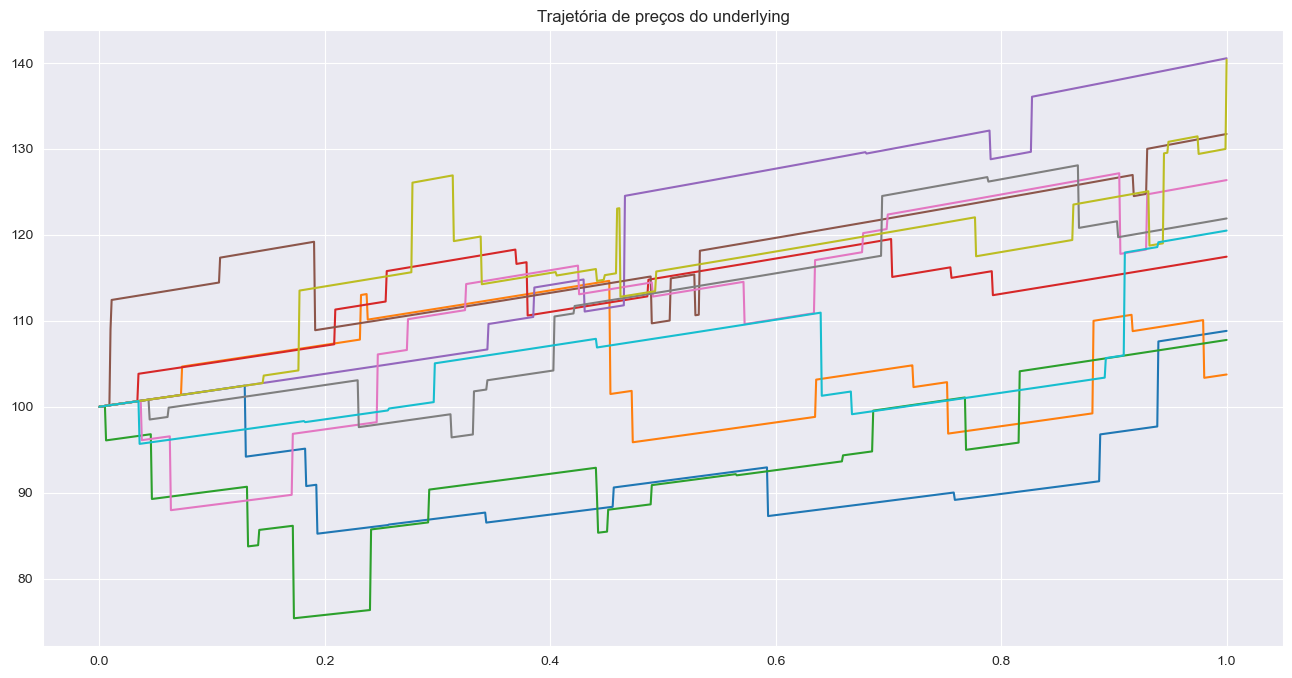

In [16]:
St = VetorSt(s0, T, sigma, mu, q, lambda_, beta_Y, sigma_Y, trajetorias, passos, ruido)

df = pd.DataFrame(St, index = np.linspace(0, T, passos + 1))
df.iloc[:, 0:10].plot(figsize=(16, 8), legend=False)
plt.title('Trajetória de preços do underlying');


## Simulação de Delta Hedging

### Delta Hedging Diffusion com Custos de Transação

In [17]:
    def delta_hedging_jump_costs(S0, T, sigma, mu, q, lambda_, beta_Y, sigma_Y, r,
                                 trajetorias, passos, TipoDerivativo,
                                 LongShort, kappa, delta_t,
                                 CallPutFlag=None, ruido='b'):

        St = VetorSt(S0, T, sigma, mu, q, lambda_, beta_Y, sigma_Y, trajetorias, passos, ruido)

        # Inicializando arrays com #linhas = passos, #colunas = trajetorias
        np_arrays = ['PosicaoDerivativo', 'StockAcc', 'BankAcc',
                     'PortfolioReplicante', 'ErroHedging',
                     'ErroHedgingAcum', 'ErroHedgingStep', 'TransCost']

        for np_array in np_arrays:
            globals()[np_array] = np.zeros((passos + 1, trajetorias))

        # Inicializando o tempo e calculando dt
        tau = T
        dt = tau / passos

        sigma_equiv = np.sqrt(sigma**2 + lambda_ *
                             (np.exp(2 * beta_Y + 2 * sigma_Y**2)
                             - 2 * np.exp(beta_Y + 0.5 * sigma_Y**2) + 1))

        delta_t = dt
        theta = (kappa / sigma_equiv) * np.sqrt(8 / (np.pi * delta_t))
        sigma_ajustado = sigma_equiv * np.sqrt(1 - LongShort * theta +
                                               LongShort * theta -
                                               LongShort * 2 * kappa * r / sigma_equiv**2)

        # Para t = 0
        V0 = preco(St[0], K, tau, r, q, sigma_ajustado, TipoDerivativo, CallPutFlag)
        delta_ = delta(St[0], K, tau, r, q, sigma_ajustado, TipoDerivativo, CallPutFlag)

        PosicaoDerivativo[0, :] = LongShort * V0
        StockAcc[0, :] = - LongShort * delta_ * St[0, :]
        BankAcc[0, :] = (- LongShort * V0) + (- StockAcc[0, :])

        # custo de transação inicial
        TransCost[0, :] = kappa * np.abs(delta_) * St[0, :]

        PortfolioReplicante[0, :] = StockAcc[0, :] + BankAcc[0, :]

        # Para instantes de tempo t tais que: 1 <= n <= passos
        for n in range(1, passos + 1):

            # Atualizando o tempo
            tau = tau - dt

            # Antes de rebalancear
            Vt = preco(St[n], K, tau, r, q, sigma_ajustado, TipoDerivativo, CallPutFlag)
            delta_novo = delta(St[n], K, tau, r, q, sigma_ajustado, TipoDerivativo, CallPutFlag)

            # Após rebalancear
            PosicaoDerivativo[n, :] = LongShort * Vt
            StockAcc[n, :] = -1 * LongShort * delta_novo * St[n, :]
            BankAcc[n, :] = (BankAcc[n-1, :] * np.exp(r * dt)
                             + LongShort * (delta_novo - delta_) * St[n, :]
                             - LongShort * delta_ * St[n-1, :] * q * dt)

            TransCost[n, :] = TransCost[n-1, :] + kappa * np.abs(delta_novo - delta_) * St[n, :]

            PortfolioReplicante[n, :] = StockAcc[n, :] + BankAcc[n, :] - TransCost[n, :]
            ErroHedgingAcum[n, :] = PortfolioReplicante[n, :] + PosicaoDerivativo[n, :]
            ErroHedgingStep[n, :] = ErroHedgingAcum[n, :] - ErroHedgingAcum[n-1, :]

            delta_ = delta_novo

        # Calculando resultados: valor do portfólio replicante, payoff, erro de hedge ($ e %)
        Resultados = {}
        Resultados['ST'] = St[n, :]
        Resultados['HT'] = PortfolioReplicante[n, :]
        Resultados['VT'] = - LongShort * payoff(St[n], K, TipoDerivativo, CallPutFlag)
        Resultados['Erro'] = Resultados['HT'] - Resultados['VT']
        Resultados['Erro/V0'] = Resultados['Erro'] / V0
        Resultados['ErroHedging'] = ErroHedgingAcum[n, :]

        # colocando os resultados em um DataFrame
        df_Resultados = (pd.DataFrame(Resultados)
                         .set_index('ST')
                         .sort_index())

        return df_Resultados


#### Grafico

In [18]:
# logcontract
# squaredlogcontract
# forward
# squaredforward
# vanilla
# digital
# sharedigital

s0 = 100
K = 100
T = 1

r = 0.1
mu = 0.2
q = 0.0
sigma = 0.40
ruido = 'b'

lambda_ = 0
beta_Y = 0.0
sigma_Y = 0.05

trajetorias = 10000
passos = 252 * 4
TipoDerivativo = 'vanilla'
CallPutFlag = 'c'
LongShort = -1  # Posição no derivativo. Long = 1, Short = -1

kappa = 0 * 50 * 10**-4
delta_t = T / passos


In [19]:
# kappa = np.arange(0, 0.1, 0.001)
# sigma_equiv = np.sqrt(sigma**2 + lambda_ * (np.exp(2 * beta_Y + 2 * sigma_Y**2)
#                        - 2 * np.exp(beta_Y + 0.5 * sigma_Y**2) + 1))
#
# theta = (kappa / sigma_equiv) * np.sqrt(8/(np.pi * delta_t))
# sigma_ajustado = sigma_equiv * np.sqrt(1 - LongShort * theta - 2*LongShort * kappa * r / sigma_equiv**2)
# sigma_ajustado


In [20]:
out01 = delta_hedging_jump_costs(s0, T, sigma, mu, q, lambda_, beta_Y, sigma_Y, r,
                                 trajetorias, passos, TipoDerivativo,
                                 LongShort, kappa, delta_t, CallPutFlag, ruido)


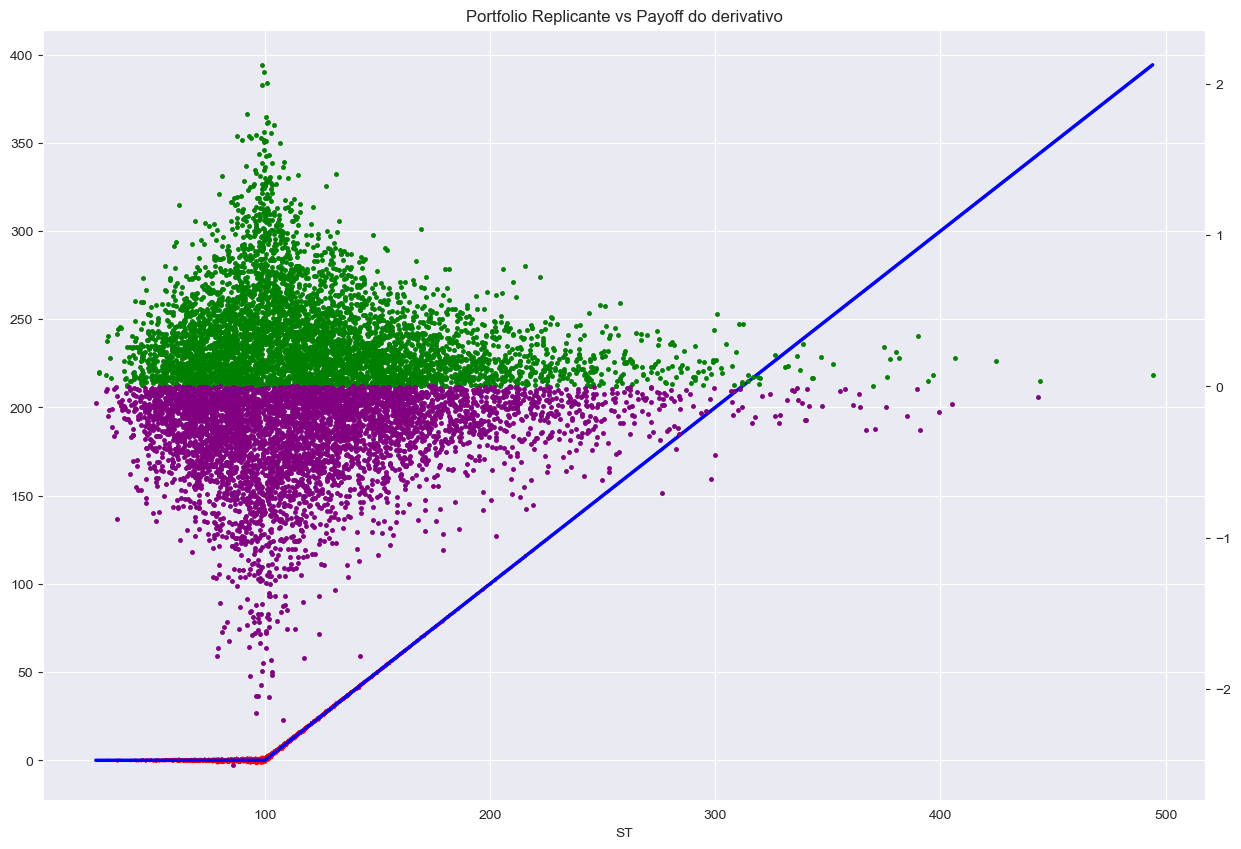

In [21]:
plt.figure(figsize=(15,10))

plt.title('Portfolio Replicante vs Payoff do derivativo')

# plt.scatter(x = out01.index, y = out01['HT'], color = 'r', alpha = 0.5, );
# plt.plot(out01.index, out01.loc[:, ['Erro']], color = 'blue', linewidth = 2.0);
# plt.plot(out01.index, out01.loc[:, ['VT', 'HT']], color = 'blue', linewidth = 2.0);
# plt.plot(out01.index, out01.loc[:, ['VT']], color = 'blue', linewidth = 2.0);
# plt.plot(out01.index, out01.loc[:, ['HT']], color = 'red', linewidth = 1.0);

HT = out01.loc[:,'HT']
HT.plot(secondary_y = False, style ='-', color = 'red', markersize = 5, markevery = 1)

VT = out01.loc[:,'VT']
VT.plot(secondary_y = False, style ='-', color = 'blue', markevery = 1, linewidth = 2.5)

erro_pos = np.maximum(out01.loc[:,'Erro'] , 0).replace(0, np.nan)
ax01 = erro_pos.plot(secondary_y = True, style ='.', color = 'green', markersize = 5, markevery = 1)

erro_neg = np.minimum(out01.loc[:,'Erro'] , 0).replace(0, np.nan)
ax02 = erro_neg.plot(secondary_y = True, style ='.', color = 'purple', markersize = 5, markevery = 1)


In [22]:
out01.describe(percentiles = [0.025, 0.05, 0.1, .25, .5, .75, 0.9, 0.95, 0.975])


,HT,VT,Erro,Erro/V0,ErroHedging
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,30.808919,30.810112,-0.001193,-0.000059,-0.001206
std,43.515301,43.516026,0.442961,0.021801,0.442950
min,-2.500196,0.000000,-2.500196,-0.123050,-2.500196
2.5%,-0.722819,0.000000,-0.919921,-0.045275,-0.919922
5%,-0.505291,0.000000,-0.723743,-0.035620,-0.723753
10%,-0.265493,0.000000,-0.526347,-0.025905,-0.526347
25%,0.137859,0.000000,-0.243716,-0.011995,-0.243726
50%,12.506473,12.545576,-0.001115,-0.000055,-0.001122
75%,47.908344,47.942253,0.248891,0.012249,0.248888


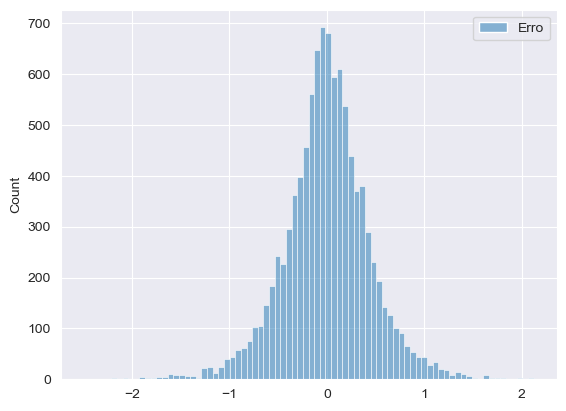

In [23]:
# plotando a distribuição do erro terminal (i.e., erro acumulado) de hedging

# com o plt.hist() os dados devem ser uma série ou um array
# dados = out01['ErroHedging']
# plt.hist(dados, bins = 100);
# plt.xlim(-50, 50);

# com o sns.histplot() de Seaborn os dados podem ser uma série, um array ou um dataframe
# dados = out01['ErroHedging']
dados = out01.loc[:, ['Erro']]
sns.histplot(data = dados, bins = 80);
# plt.xlim(-50, 50);


In [24]:
# Calculando estatísticas do erro terminal
out01.iloc[:, -3:-1].describe(percentiles = [0.1, .25, .5, .75, 0.9])


,Erro,Erro/V0
count,10000.000000,10000.000000
mean,-0.001193,-0.000059
std,0.442961,0.021801
min,-2.500196,-0.123050
10%,-0.526347,-0.025905
25%,-0.243716,-0.011995
50%,-0.001115,-0.000055
75%,0.248891,0.012249
90%,0.512669,0.025232
max,2.126206,0.104644


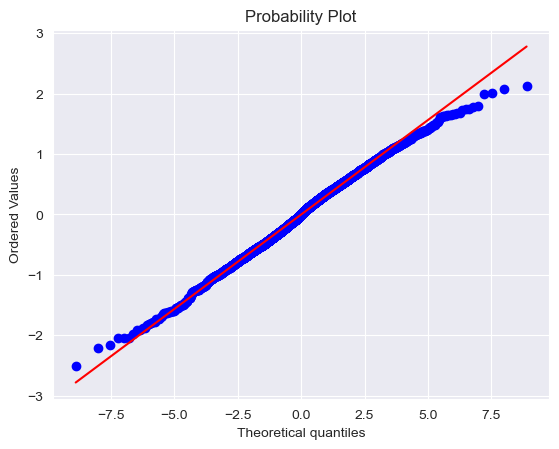

In [25]:
# plotando probplot do erro terminal
dados = out01['ErroHedging']
# probplot(dados, dist = 'norm', plot = plt);
probplot(dados, dist = 'laplace', plot = plt);


## Análise de Frequencia de Balanceamentos

In [18]:
# logcontract
# squaredlogcontract
# forward
# squaredforward
# vanilla

s0 = 100
K = 100
T = 1

r = 0.1
mu = 0.2
q = 0.0
sigma = 0.45
ruido = 'l'

lambda_ = 0.0
beta_Y = 0.0
sigma_Y = 0.0

trajetorias = 40 * 10**3
lista_passos = range(10, 250, 10)

TipoDerivativo = 'vanilla'
CallPutFlag = 'c'
LongShort = -1  # Posição no derivativo. Long = 1, Short = -1

kappa = 0 * 10**-4
delta_t = T / passos


In [19]:
dict_res = {}

for passos in lista_passos:

    out01 = delta_hedging_jump_costs(s0, T, sigma, mu, q, lambda_, beta_Y, sigma_Y, r,
                                     trajetorias, passos, TipoDerivativo, LongShort,
                                     kappa, delta_t, CallPutFlag, ruido)

    erros = out01.loc[:, 'Erro']
    lista_percentis = range(10, 100, 10)
    percentis = np.percentile(erros, q = lista_percentis)
    dict_res[passos] = percentis
    df = pd.DataFrame(dict_res, index = lista_percentis).T

df


,10,20,30,40,50,60,70,80,90
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,-6.360194,-3.420695,-1.722877,-0.484329,0.578970,1.583663,2.678419,3.951767,5.809649
30,-5.216354,-2.875726,-1.496880,-0.461429,0.422734,1.278033,2.191939,3.271381,4.909623
40,-4.648107,-2.574993,-1.344938,-0.466062,0.305610,1.036901,1.863265,2.816000,4.266065
50,-4.094981,-2.328252,-1.235331,-0.448159,0.249932,0.920888,1.636579,2.525680,3.847733
60,-3.712449,-2.105180,-1.146936,-0.417032,0.224661,0.839322,1.501509,2.294310,3.471501
70,-3.441565,-1.959448,-1.092779,-0.411667,0.181142,0.769211,1.383872,2.168182,3.321194
80,-3.233194,-1.835974,-1.006144,-0.381206,0.157139,0.686805,1.262859,1.988947,3.057519
90,-3.046494,-1.762216,-0.984211,-0.389085,0.139236,0.650769,1.201321,1.876203,2.882088
100,-2.858174,-1.658368,-0.910501,-0.343593,0.151989,0.643315,1.156733,1.795081,2.775495


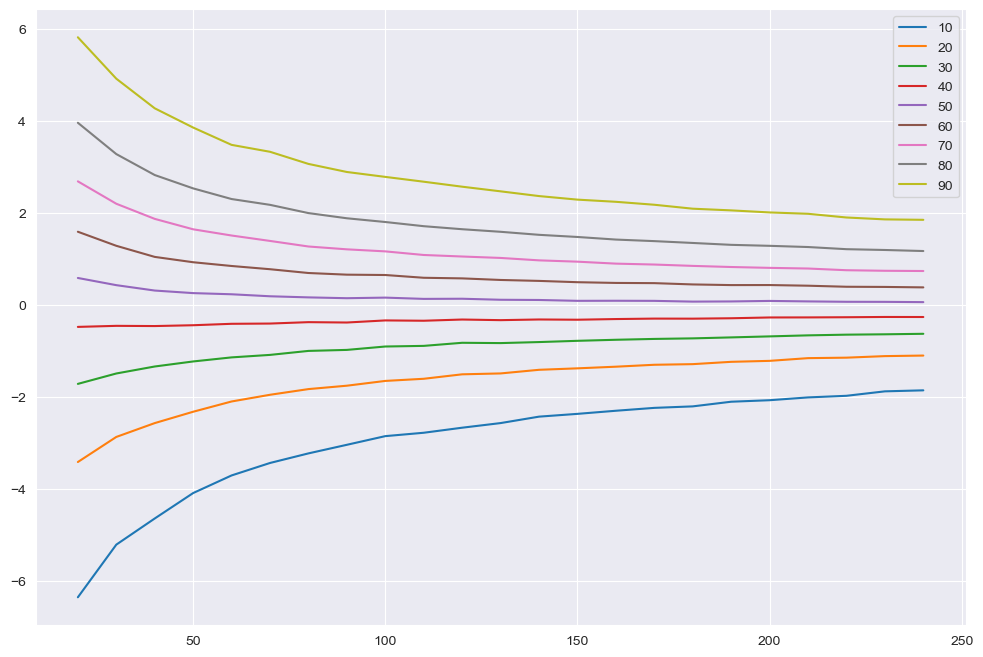

In [20]:
df.plot(figsize = (12, 8));
